# Diabetes Classifier - Baseline Model (Logistic Regression)

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')

In [68]:
def robust_scale(column):
    median = np.median(column)
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    return (column - median) / iqr

class LogisticRegression:

    def __init__(self, X, y, alpha, epsilon, epochs, gd, sgd=False) -> None:
        self.X = X
        self.y = y
        self.alpha = alpha
        self.epsilon = epsilon
        self.epochs = epochs
        self.gd = gd
        self.sgd = sgd
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def train_test_split(self):
        strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=17)
        for train_idx, test_idx in strat_split.split(self.X, self.y):
            self.X_train = self.X.iloc[train_idx]
            self.X_test = self.X.iloc[test_idx]
            self.y_train = self.y.iloc[train_idx].values.ravel()
            self.y_test = self.y.iloc[test_idx].values.ravel()
    
    def scale_xTrain(self):
        self.X_train['GenHlth'] = 6 - self.X_train['GenHlth']
        numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']
        self.X_train[numerical_cols] = self.X_train[numerical_cols].apply(robust_scale)
        self.X_train = self.add_bias(self.X_train)
    
    def scale_xTest(self):
        self.X_test['GenHlth'] = 6 - self.X_test['GenHlth']
        numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']
        self.X_test[numerical_cols] = self.X_test[numerical_cols].apply(robust_scale)
        self.X_test = self.add_bias(self.X_test)
    
    def add_bias(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.c_[np.ones((X.shape[0], 1)), X]
    
    def predict_probability(self, X):
        return self.sigmoid(X.dot(self.w))
    
    def predict(self, X):
        return (self.predict_probability(X) >= 0.5).astype(int)
    
    def cost_function(self, X, y):
        m = X.shape[0]
        h = self.predict_probability(X)
        return (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    
    def derivative(self, X, y):
        m = X.shape[0]
        error = self.predict_probability(X) - y
        return (1/m) * X.T.dot(error)
    
    def gradient_descent(self, X, y):
        errors = []
        last_error = float('inf')
        
        for i in range(self.epochs):
            gradient = self.derivative(X, y)
            self.w -= self.alpha * gradient
            error = self.cost_function(X, y)
            errors.append(error)
            if abs(error - last_error) < self.epsilon:
                print(f"Converged at iteration {i}")
                break
            last_error = error
        
        self.plot_loss(errors)
    
    def stochastic_gradient_descent(self, X, y):
        errors = []
        last_error = float('inf')

        for i in range(self.epochs):
            for j in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                x_i = X[random_index:random_index+1]
                y_i = y[random_index:random_index+1]
                gradient = self.derivative(x_i, y_i)
                self.w -= self.alpha * gradient
            
            error = self.cost_function(X, y)
            errors.append(error)
            if abs(error - last_error) < self.epsilon:
                print(f"Converged at iteration {i}")
                break
            last_error = error
        
        self.plot_loss(errors)

    def fit(self):
        self.train_test_split()
        self.scale_xTest()
        self.scale_xTrain()
        self.w = np.random.randn(self.X_train.shape[1]) * np.sqrt(2/self.X_train.shape[1])
        
        if self.sgd:
            self.stochastic_gradient_descent(self.X_train, self.y_train)
        else:
            self.gradient_descent(self.X_train, self.y_train)
        
        self.report_metrics()
    
    def plot_loss(self, loss_sequence):
        plt.plot(np.arange(len(loss_sequence)), loss_sequence)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training Loss over Iterations')
        plt.grid(True)
        plt.show()
    
    def report_metrics(self):
        y_pred = self.predict(self.X_test)
        accuracy = np.mean(y_pred == self.y_test)
        print(f"Accuracy: {accuracy:.4f}")


### Testing on Balanced dataset

In [69]:
diabetes_balanced = pd.read_csv(r"C:\Users\karni\OneDrive\Documents\GitHub\diabetes-classifier\data\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
diabetes_balanced.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [70]:
X = diabetes_balanced.drop('Diabetes_binary', axis=1)
y = diabetes_balanced[['Diabetes_binary']]

### Gradient Descent

In [ ]:
logistic_regression = LogisticRegression(X, y, alpha=0.001, epsilon=0.000001, epochs=20000, gd=True)
logistic_regression.fit()

### Stochastic Gradient Descent

Converged at iteration 17371


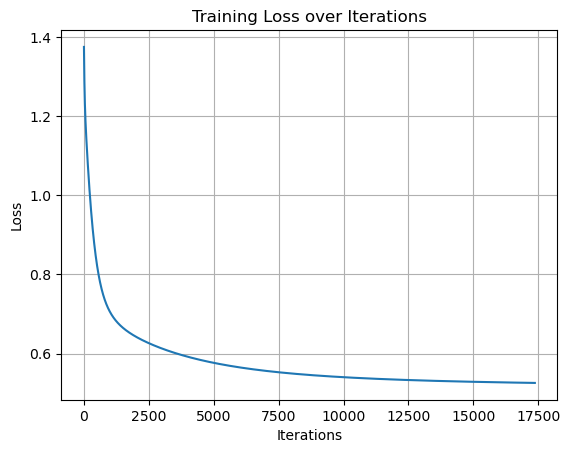

Accuracy: 0.7344


In [ ]:
logistic_regression_sgd = LogisticRegression(X, y, alpha=0.001, epsilon=0.000001, epochs=20000, gd=True)
logistic_regression_sgd.fit()